# Fine Tuning Bert for common dataset

<a id='section01'></a>
### Импорт библиотек

In [ ]:
!pip install transformers
!pip install sklearn
!pip install torch
!pip install comet-ml
!pip install numpy
!pip install pandas

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import regex as re

import comet_ml
from comet_ml import Experiment

import transformers
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
from torch import cuda
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

<a id='section02'></a>
### Инициализация функций

In [ ]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

In [ ]:
def statistic(y_pred_test, y_test, y_pred_train, y_train,
             t1, t2):
    score_table = pd.DataFrame(columns=(t1, t2))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [ ]:
def set_experiment(api_key, project_name, workspace):
    experiment = Experiment(
    api_key=api_key,
    project_name=project_name,
    workspace=workspace
)
    
    return experiment

In [ ]:
def log_parameters(experiment, hyper_params):
    experiment.log_parameter("train_batch_size", hyper_params['batch_size'])
    experiment.log_parameter("test_batch_size", hyper_params['batch_size'])

    experiment.log_parameter("Learning Rate", hyper_params['lr'])
    experiment.log_parameter("general_epochs", hyper_params['epochs'])
    experiment.log_parameter("max_len", hyper_params['max_len'])

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Text
        self.targets = dataframe.Class
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, freeze_bert=False):
        
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 3

        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask, token_type_ids):

        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        pooler_output = outputs.pooler_output
        logits = self.classifier(pooler_output)

        return logits

In [ ]:
api_key = ххх
project_name = ххх
workspace = ххх"

experiment = set_experiment(api_key, project_name, workspace)

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'

<a id='section03'></a>
### Работа с данными

In [ ]:
X_train = pd.read_csv('train.csv', header=0)
X_dev = pd.read_csv('dev.csv', header=0)
X_test = pd.read_csv('test.csv', header=0)

In [12]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    per_pattern = re.compile(r'@[^\s]+')
    return per_pattern.sub(r'', url_pattern.sub(r'', text))

In [13]:
X_test

,Text,Class
0,"как же она выросла :""3 https://t.co/zJdoveCqA7",0
1,Класс. Всегда мечтала отметить новый год в бол...,2
2,@publikatsii_ru @M5NZyOhxPbaRTaE Понятно почем...,0
3,@imerkouri Куда долетели?,0
4,"нога затекла, а я боюсь менять положение ааааа...",2
...,...,...
3200,@asitfans Тебе отвечаю😅☺️💛💛,1
3201,@disap_pear_fuck АХАХ кстати оригинально он во...,0
3202,"Итак, в два часа ночи мы выяснили, что я остав...",2
3203,Intel - Взгляд в Будущее. Рынок процессоров в ...,0


In [14]:
X_train['Text'] = [remove_urls(i) for i in X_train['Text']]
X_dev['Text'] = [remove_urls(i) for i in X_dev['Text']]
X_test['Text'] = [remove_urls(i) for i in X_test['Text']]

In [15]:
X_test

,Text,Class
0,"как же она выросла :""3",0
1,Класс. Всегда мечтала отметить новый год в бол...,2
2,Понятно почему Голландия.,0
3,Куда долетели?,0
4,"нога затекла, а я боюсь менять положение ааааа...",2
...,...,...
3200,Тебе отвечаю😅☺️💛💛,1
3201,АХАХ кстати оригинально он вообще по плечи бы...,0
3202,"Итак, в два часа ночи мы выяснили, что я остав...",2
3203,Intel - Взгляд в Будущее. Рынок процессоров в ...,0


In [16]:
EMOTICONS = {
    u":‑\)":"улыбка",
    u":\)":"улыбка",
    u":-\]":"улыбка",
    u":\]":"улыбка",
    u":-3":"улыбка",
    u":3":"улыбка",
    u":->":"улыбка",
    u":>":"улыбка",
    u"8-\)":"улыбка",
    u":o":"удивление",
    u":о":"удивление",
    u":-\}":"улыбка",
    u":\}":"улыбка",
    u":-\)":"улыбка",
    u":c":"грустно",
    u":с":"грустно",
    u":\)":"улыбка",
    u":\^\)":"улыбка",
    u"=\]":"улыбка",
    u"=\)":"улыбка",
    u":‑D":"смешно",
    u":D":"смешно",
    u"хд":"смешно",
    u"хД":"смешно",
    u"ХД":"смешно",
    u"8‑D":"смешно",
    u"8D":"смешно",
    u"X‑D":"смешно",
    u"XD":"смешно",
    u"=D":"смешно",
    u"=\*":"поцелуй",
    u"=3":"смешно",
    u"B\^D":"смешно",
    u":-\)\)":"очень счастлив",
    u":‑\(":"грустно",
    u":-\(":"грустно",
    u":\(":"грустно",
    u":‑c":"грустно",
    u":c":"грустно",
    u":‑<":"грустно",
    u":<":"грустно",
    u":‑\[":"грустно",
    u":\[":"грустно",
    u":-\|\|":"грустно",
    u">:\[":"грустно",
    u":\{":"грустно",
    u":@":"грустно",
    u">:\(":"грустно",
    u":'‑\(":"плачу",
    u":'\(":"плачу",
    u":'‑\)":"слезы счастья",
    u":'\)":"слезы счастья",
    u"D‑':":"страх",
    u"D:<":"отвращение",
    u"D:":"грусть",
    u"D8":"тревога",
    u"D;":"тревога",
    u"D=":"тревога",
    u"DX":"тревога",
    u":‑O":"удивление",
    u":O":"удивление",
    u":‑o":"удивление",
    u":o":"удивление",
    u":-0":"шок",
    u"8‑0":"зевать",
    u">:O":"зевать",
    u":-\*":"поцелуй",
    u":\*":"поцелуй",
    u":X":"поцелуй",
    u";‑\)":"подмигнуть или ухмыльнуться",
    u";\)":"подмигнуть или ухмыльнуться",
    u"\*-\)":"подмигнуть или ухмыльнуться",
    u"\*\)":"подмигнуть или ухмыльнуться",
    u";‑\]":"подмигнуть или ухмыльнуться",
    u";\]":"подмигнуть или ухмыльнуться",
    u";\^\)":"подмигнуть или ухмыльнуться",
    u":‑,":"подмигнуть или ухмыльнуться",
    u";D":"подмигнуть или ухмыльнутьсяk",
    u":‑P":"высовывает язык, дерзкий, игривый",
    u":P":"высовывает язык, дерзкий, игривый",
    u"X‑P":"высовывает язык, дерзкий, игривый",
    u"XP":"высовывает язык, дерзкий, игривый",
    u":‑Þ":"высовывает язык, дерзкий, игривый",
    u":Þ":"высовывает язык, дерзкий, игривый",
    u":b":"высовывает язык, дерзкий, игривый",
    u"d:":"высовывает язык, дерзкий, игривый",
    u"=p":"высовывает язык, дерзкий, игривый",
    u">:P":"высовывает язык, дерзкий, игривый",
    u":‑/":"скептичный, раздраженный, нерешительный",
    u":/":"скептичный, раздраженный, нерешительный",
    u":-[.]":"скептичный, раздраженный, нерешительный",
    u">:[(\\\)]":"скептичный, раздраженный, нерешительный",
    u">:/":"скептичный, раздраженный, нерешительный",
    u":[(\\\)]":"скептичный, раздраженный, нерешительный",
    u"=/":"скептичный, раздраженный, нерешительный",
    u"=[(\\\)]":"скептичный, раздраженный, нерешительный",
    u":L":"скептичный, раздраженный, нерешительный",
    u"=L":"скептичный, раздраженный, нерешительный",
    u":S":"скептичный, раздраженный, нерешительный",
    u":‑\|":"бесстрастный",
    u":\|":"бесстрастный",
    u":$":"смущен",
    u":‑x":"молчание",
    u":x":"молчание",
    u":‑#":"молчание",
    u":#":"молчание",
    u":‑&":"молчание",
    u":&":"молчание",
    u"O:‑\)":"ангел, невинность",
    u"О:‑\)":"ангел, невинность",
    u"O:\)":"ангел, невинность",
    u"О:\)":"ангел, невинность",
    u"0:‑3":"ангел, невинностьt",
    u"0:3":"ангел, невинность",
    u"0:‑\)":"ангел, невинность",
    u"0:\)":"ангел, невинность",
    u":‑b":"высовывает язык, дерзкий, игривый",
    u"0;\^\)":"ангел, невинность",
    u">:‑\)":"зло, дьявольский",
    u">:\)":"зло, дьявольский",
    u"\}:‑\)":"зло, дьявольский",
    u"\}:\)":"зло, дьявольский",
    u"3:‑\)":"зло, дьявольский",
    u"3:\)":"зло, дьявольский",
    u">;\)":"зло, дьявольский",
    u"\|;‑\)":"крутой",
    u"\|‑O":"скучный",
    u":‑J":"ироничный",
    u"#‑\)":"веселье",
    u"%‑\)":"пьян или смущен",
    u"%\)":"пьян или смущен",
    u":-###..":"болеет",
    u":###..":"болеет",
    u"<:‑\|":"дурак",
    u"\(>_<\)":"проблема",
    u"\(>_<\)>":"проблема",
    u"\(';'\)":"малыш",
    u"\(\^\^>``":"нервничает, или смущен, или обеспокоен, или застенчив, или обливается потом",
    u"\(\^_\^;\)":"нервничает, или смущен, или обеспокоен, или застенчив, или обливается потом",
    u"\(-_-;\)":"нервничает, или смущен, или обеспокоен, или застенчив, или обливается потом",
    u"\(~_~;\) \(・\.・;\)":"нервничает, или смущен, или обеспокоен, или застенчив, или обливается потом",
    u"\(-_-\)zzz":"спит",
    u"\(\^_-\)":"подмигивает",
    u"\(\(\+_\+\)\)":"смущен",
    u"\(\+o\+\)":"смущен",
    u"\(o\|o\)":"сверхчеловек",
    u"\^_\^":"радостный",
    u"\(\^_\^\)/":"радостный",
    u"\(\^O\^\)／":"радостный",
    u"\(\^o\^\)／":"радостный",
    u"\(__\)":"уважение или извинение",
    u"_\(\._\.\)_":"уважение или извинение",
    u"<\(_ _\)>":"уважение или извинение",
    u"<m\(__\)m>":"уважение или извинение",
    u"m\(__\)m":"уважение или извинение",
    u"m\(_ _\)m":"уважение или извинение",
    u"\('_'\)":"грустный или плачет",
    u"\(/_;\)":"грустный или плачет",
    u"\(T_T\) \(;_;\)":"грустный или плачет",
    u"\(;_;":"грустный или плачет",
    u"\(;_:\)":"грустный или плачет",
    u"\(;O;\)":"грустный или плачет",
    u"\(:_;\)":"грустный или плачет",
    u"\(ToT\)":"грустный или плачет",
    u";_;":"грустный или плачет",
    u";-;":"грустный или плачет",
    u";n;":"грустный или плачет",
    u";;":"грустный или плачет",
    u"Q\.Q":"грустный или плачет",
    u"T\.T":"грустный или плачет",
    u"QQ":"грустный или плачет",
    u"Q_Q":"грустный или плачет",
    u"\(-\.-\)":"стыд",
    u"\(-_-\)":"стыд",
    u"\(一一\)":"стыд",
    u"\(；一_一\)":"стыд",
    u"\(=_=\)":"усталость",
    u"\(=\^\·\^=\)":"кот",
    u"\(=\^\·\·\^=\)":"кот",
    u"=_\^=	":"кот",
    u"\(\.\.\)":"смотреть вниз",
    u"\(\._\.\)":"смотреть вниз",
    u"\^m\^":"смеяться",
    u"\(\・\・?":"смущение",
    u">\^_\^<":"смех",
    u"<\^!\^>":"смех",
    u"\^/\^":"смех",
    u"\（\*\^_\^\*）" :"смех",
    u"\(\^<\^\) \(\^\.\^\)":"смех",
    u"\(^\^\)":"смех",
    u"\(\^\.\^\)":"смех",
    u"\(\^_\^\.\)":"смех",
    u"\(\^_\^\)":"смех",
    u"\(\^\^\)":"смех",
    u"\(\^J\^\)":"смех",
    u"\(\*\^\.\^\*\)":"смех",
    u"\(\^—\^\）":"смех",
    u"\(#\^\.\^#\)":"смех",
    u"\（\^—\^\）":"махать",
    u"\(;_;\)/~~~":"махать",
    u"\(\^\.\^\)/~~~":"махать",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"махать",
    u"\(T_T\)/~~~":"махать",
    u"\(ToT\)/~~~":"махать",
    u"\(\*\^0\^\*\)":"удивиться",
    u"\(\*_\*\)":"удивиться",
    u"\(\*_\*;":"удивиться",
    u"\(\+_\+\) \(@_@\)":"удивиться",
    u"\(\*\^\^\)v":"улыбаться",
    u"\(\^_\^\)v":"улыбаться",
    u"\(\(d[-_-]b\)\)":"слушать музыку",
    u'\(-"-\)':"волноваться",
    u"\(ーー;\)":"волноваться",
    u"\(\^0_0\^\)":"удивлен или смущен",
    u"\(\＾ｖ\＾\)":"счастье",
    u"\(\＾ｕ\＾\)":"счастье",
    u"\(\^\)o\(\^\)":"счастье",
    u"\(\^O\^\)":"счастье",
    u"\(\^o\^\)":"счастье",
    u"\)\^o\^\(":"счастье",
    u"o_O":"удивление",
    u":O":"удивление",
    u"о_О":"удивление",
    u":О":"удивление",
    u"o_0":"удивление",
    u"о_0":"удивление",
    u"o\.O":"удивление",
    u"\(o\.o\)":"удивление",
    u"oO":"удивление",
    u"оО":"удивление",
    u"\(\*￣m￣\)":"недовольный",
    u"\(‘A`\)":"сдаться",
    u":\"3": "милый"
}

In [17]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)


In [18]:
X_train['Text'] = [remove_emoticons(i) for i in X_train['Text']]
X_dev['Text'] = [remove_emoticons(i) for i in X_dev['Text']]
X_test['Text'] = [remove_emoticons(i) for i in X_test['Text']]

In [19]:
X_test

,Text,Class
0,как же она выросла,0
1,Класс. Всегда мечтала отметить новый год в бол...,2
2,Понятно почему Голландия.,0
3,Куда долетели?,0
4,"нога затекла, а я боюсь менять положение ааааа...",2
...,...,...
3200,Тебе отвечаю😅☺️💛💛,1
3201,АХАХ кстати оригинально он вообще по плечи бы...,0
3202,"Итак, в два часа ночи мы выяснили, что я остав...",2
3203,Intel - Взгляд в Будущее. Рынок процессоров в ...,0


In [20]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [21]:
X_train['Text'] = [remove_emojis(i) for i in X_train['Text']]
X_dev['Text'] = [remove_emojis(i) for i in X_dev['Text']]
X_test['Text'] = [remove_emojis(i) for i in X_test['Text']]

In [22]:
X_test

,Text,Class
0,как же она выросла,0
1,Класс. Всегда мечтала отметить новый год в бол...,2
2,Понятно почему Голландия.,0
3,Куда долетели?,0
4,"нога затекла, а я боюсь менять положение ааааа...",2
...,...,...
3200,Тебе отвечаю,1
3201,АХАХ кстати оригинально он вообще по плечи бы...,0
3202,"Итак, в два часа ночи мы выяснили, что я остав...",2
3203,Intel - Взгляд в Будущее. Рынок процессоров в ...,0


<a id='section04'></a>
### Подготовка dataloader

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

parameters = {
    'batch_size': 32,
    'lr': 5e-5,
    'epochs': 15,
    'max_len': 256,
}

log_parameters(experiment, parameters)

In [ ]:
print("TRAIN Dataset: {}".format(X_train.shape))
print("DEV Dataset: {}".format(X_dev.shape))
print("TEST Dataset: {}".format(X_test.shape))

training_set = CustomDataset(X_train, tokenizer, parameters['max_len'])
dev_set = CustomDataset(X_dev, tokenizer, parameters['max_len'])
testing_set = CustomDataset(X_test, tokenizer, parameters['max_len'])

In [ ]:
train_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': parameters['batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
dev_loader = DataLoader(dev_set, **test_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section05'></a>
### Fine Tuning

In [ ]:
bert_classifier = BertClassifier(freeze_bert=False)
bert_classifier.to(device)

experiment.set_model_graph(bert_classifier, True)

optimizer = AdamW(bert_classifier.parameters(),
                      lr=parameters['lr'],
                      eps=1e-8 
                      )

total_steps = len(training_loader) * parameters['epochs']

scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

In [27]:
import time
from copy import deepcopy 

loss_fn = nn.CrossEntropyLoss()
global_balanced_acc = 0
best_model_params = deepcopy(bert_classifier.state_dict())

step = 0

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, data in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            b_labels = data['targets'].to(device, dtype = torch.long)
        
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(ids, mask, token_type_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                
                experiment.log_metric('loss_train_steps', batch_loss / batch_counts)
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        experiment.log_metric('loss_train', avg_train_loss)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    
    global global_balanced_acc, step

    model.eval()

    val_accuracy = []
    val_loss = []
    
    all_preds = []
    all_labels = []

    for data in val_dataloader:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        b_labels = data['targets'].to(device, dtype = torch.long)
        
        with torch.no_grad():
            logits = model(ids, mask, token_type_ids)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()
        
        all_preds += preds.tolist()
        all_labels += b_labels.tolist()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    experiment.log_metric('loss_val', val_loss)
    
    b_accuracy = balanced_accuracy_score(all_labels, all_preds)
    print('Balanced_accuracy know: ', b_accuracy)
    experiment.log_metric('loss_b_accuracy', b_accuracy)
    
    if b_accuracy > global_balanced_acc:
        global_balanced_acc = b_accuracy
        best_model_params = deepcopy(model.state_dict())
        
        output_model_file = f'second_bert_sentiment_{round(b_accuracy, 5)}_{step}.bin'

        model_to_save = model
        torch.save(model_to_save, output_model_file)

    return val_loss, val_accuracy

In [28]:
train(bert_classifier, training_loader, dev_loader, epochs=parameters['epochs'], evaluation=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   100   |   0.972029   |     -      |     -     |  130.43  
   1    |   200   |   0.839915   |     -      |     -     |  127.68  
   1    |   300   |   0.804367   |     -      |     -     |  127.75  
   1    |   320   |   0.748836   |     -      |     -     |   24.85  
----------------------------------------------------------------------
Balanced_accuracy know:  0.6790176716837631
   1    |    -    |   0.864735   |  0.751019  |   67.98   |  454.53  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   100   |   0.692754   |     -      |     -     |  129.11  
   2    |   200   |   0.698254   |     -      |     -     |  127.59  
   2    |   300   |  

<a id='section06'></a>
### Результаты

In [29]:
def get_predicts(model, loader, _type_):
    
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_preds, all_labels = [], []
    
    
    with torch.no_grad():
        for _, data in (enumerate(loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            b_labels = data['targets'].to(device, dtype = torch.long)

            logits = model(ids, mask, token_type_ids)
            preds = torch.argmax(logits, dim=1).flatten()

            all_preds += preds.tolist()
            all_labels += b_labels.tolist()

    
    return all_preds, all_labels


In [30]:
model = torch.load('/content/second_bert_sentiment_0.70632_0.bin')

model.eval()
None

In [31]:
y_pred_test, y_test = get_predicts(model, testing_loader, 'Test')
y_pred_train, y_train = get_predicts(model, training_loader, 'Train')
y_pred_val, y_val = get_predicts(model, dev_loader, 'Validation')

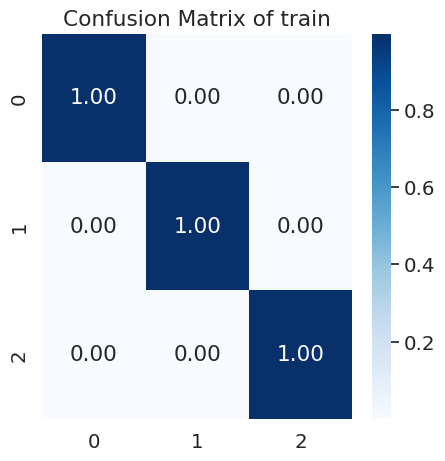

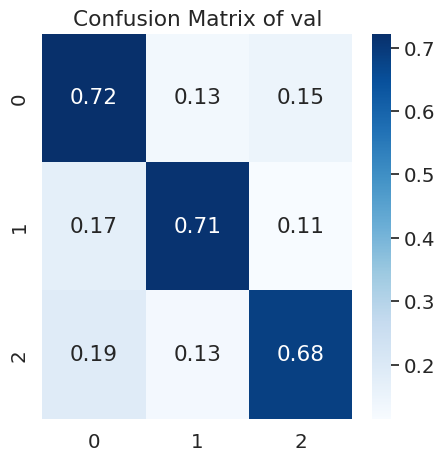

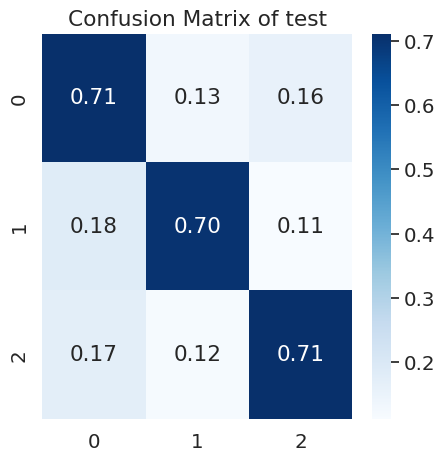

In [33]:
cm_plot(y_train, y_pred_train, 'train')
cm_plot(y_val, y_pred_val, 'val')
cm_plot(y_test, y_pred_test, 'test')

In [37]:
statistic(y_pred_test, y_test, y_pred_train, y_train, 'train', 'test')

,train,test
balanced_accuracy_score,0.996197,0.707958
accuracy_score,0.996197,0.707956
f1 weighted,0.996198,0.708328
f1 micro,0.996197,0.707956
f1 macro,0.996198,0.708324


In [38]:
statistic(y_pred_train, y_train, y_pred_val, y_val, 'dev', 'train')

,dev,train
balanced_accuracy_score,0.706321,0.996197
accuracy_score,0.706318,0.996197
f1 weighted,0.70655,0.996198
f1 micro,0.706318,0.996197
f1 macro,0.706556,0.996198


In [39]:
from google.colab import files
from google.colab import drive

In [40]:
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [42]:
!cp second_bert_sentiment_0.70632_0.bin ххх

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>